In [36]:
import pandas as pd
from pathlib import Path
import numpy as np
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.inter_rater import fleiss_kappa as fleiss_kappa_calc

In [56]:
def create_rating_plot(df, kappa, repeats=100, pipeline_name="", save=False):
    #drop the scan column
    df = df.drop(columns='scan')
    f,ax = plt.subplots(1,1, figsize=(25,5))
    #get the array matrix from the dataframe
    mat = df.values.T
    rep_mat = np.repeat(mat, repeats=repeats, axis=0)
    #rep_mat = np.repeat(rep_mat, repeats=4, axis=1)
    #print(rep_mat.shape)
    ax.imshow(rep_mat, cmap=cmap, aspect='auto', interpolation='none')
    #show horizontal grid lines, with two lines between quarter of the plot
    num_rows, num_cols = rep_mat.shape
    x_ticks = [0, num_cols // 4, num_cols // 2, 3 * num_cols // 4, num_cols - 1]
    y_ticks = [0, num_rows // 4, num_rows // 2, 3 * num_rows // 4, num_rows - 1]

    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f'{tick}' for tick in x_ticks])  # Optional: label as values
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{tick}' for tick in y_ticks])  # Optional: label as values

    #ax.set_yticks(np.arange(len(df.columns) + 1) - .5, minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    for y in y_ticks:
        ax.hlines(y, xmin=0, xmax=num_cols - 1, colors='black', linewidth=3)

    #set the rater names on the plot
    y_labels = ['rater_1', 'rater_2', 'rater_3', 'rater_4']
    y_tick_pos = [x*repeats*len(y_labels) for x in [0.12, 0.37, 0.62, 0.87]]
    ax.set_yticks(y_tick_pos)
    ax.set_yticklabels(y_labels, fontsize=15)
    #remove yticks
    ax.yaxis.set_ticks_position('none')

    #remove the xticks and labels
    ax.set_xticks([])
    ax.set_xticklabels([])

    #set the x-axis label
    ax.set_xlabel(r"Quality Controlled Outputs ( $N=${} )".format(num_cols), fontsize=14)

    ax.set_title(f"Quality Control Ratings for {pipeline_name}\n" + r"Fleiss' $\kappa$: {:.3f}".format(kappa), fontsize=16)
    #ax.set_title(r"$\text{Quality Control Ratings for {}}\n\text{Fleiss' }\kappa: {:.2f}$".format(pipeline_name, kappa))


    if save:
        f.savefig(f"{pipeline_name}_quality_control.png", dpi=600)
    #close the plot
    plt.close(f)

def compute_fleiss_kappa(df):
    """
    
    """
    #get the dataframe into the form where columns are "num_yes", "num_maybe", "num_no" instead of the raters
    num_raters = len(df.columns) - 1
    #create a new dataframe with the columns "num_yes", "num_maybe", "num_no"
    new_df = pd.DataFrame(columns=['scan', 'num_yes', 'num_maybe', 'num_no'])
    #iterate through the rows of the dataframe
    for i, row in df.iterrows():
        #get the scan name
        scan = row['scan']
        #get the values of the row
        values = row[1:]
        #count the number of "yes", "maybe", and "no" ratings
        num_yes = len(values[values == 'yes'])
        num_maybe = len(values[values == 'maybe'])
        num_no = len(values[values == 'no'])
        #add the values to the new dataframe
        new_row = {'scan': scan, 'num_yes': num_yes, 'num_maybe': num_maybe, 'num_no': num_no}
        new_df = pd.concat([new_df, pd.Series(new_row).to_frame().T], axis=0)
    #compute the fleiss kappa
    f_kappa = fleiss_kappa_calc(new_df[['num_yes', 'num_maybe', 'num_no']].values, method='fleiss')
    return f_kappa


def cm_scores(df, rater1, rater2):
    array = np.zeros((3,3))
    for i,rating_1 in enumerate(['yes', 'maybe', 'no']):
        for j,rating_2 in enumerate(['yes', 'maybe', 'no']):
            value = len(df[(df[rater1] == rating_1) & (df[rater2] == rating_2)])
            array[i,j] = value
    #add the corresponding off diagonal values together
    ym = array[0,1] + array[1,0]
    yn = array[0,2] + array[2,0]
    mn = array[1,2] + array[2,1]
    array[0,1] = ym
    array[1,0] = ym
    array[0,2] = yn
    array[2,0] = yn
    array[1,2] = mn
    array[2,1] = mn
    return array
    #         try:
    #             value = cm.loc[rating_1, rating_2]
    #         except:
    #             print(cm)
    #             value = cm.loc[rating_1, rating_2]
    #         array[i,j] = value
    # return array

#create the colormap
categories = ['no', 'maybe', 'yes']
#use a ListedColormap with #E63946, #457B9D, and #2A9D8F
#cmap = ListedColormap(['#D55E00', '#3178C6', '#009E73'])
#cmap = ListedColormap(['#D55E00', '#3178C6', '#A9DDFD'])
#cmap = ListedColormap(['#D55E00', '#FF8C00', '#A9DDFD'])
cmap = ListedColormap(['#8B0000', '#FFDB58', '#A9DDFD'])

#cmap = ListedColormap(['red', 'yellow', 'green'])


root = Path("/fs5/p_masi/kimm58/InterRaterVariability/")

pipelines = ["SLANT-TICVv1.2", "PreQual", "T1w", "TractsegAFright", "TractsegCC4", "TractsegCSTleft", "TractsegSLFIleft", "TractsegTPOSTCright"]
raters = ['rater_1', 'rater_2', 'rater_3', 'rater_4']
all_classes = ['yes', 'maybe', 'no']

pipeline_dfs = {}

for pipeline in tqdm(pipelines):
    #pipeline_df = pd.DataFrame()
    dfs = []
    # if pipeline == "SLANT-TICVv1.2":
    #     continue
    for rater in raters:
        #grab the QA csv file
        qa_f = root / rater / pipeline / "QA.csv"
        #print(qa_f)
        qa = pd.read_csv(qa_f)
        #concatenate the sub,ses,acq,run columns into a single column
        qa['scan'] = qa['sub'].fillna('') + "_" + qa['ses'].fillna('') + "_" + qa['acq'].fillna('') + "_" + qa['run'].fillna('')
        #grab the columns of QA status and scan only
        qa = qa[['scan', 'QA_status']]
        #rename the QA column to the rater name
        qa = qa.rename(columns={'QA_status': rater})
        dfs.append(qa)
        continue
        #merge the QA column to the pipeline_df
        try:
            print(qa.shape)
            pipeline_df = pd.merge(pipeline_df, qa, on='scan', how='outer')
        except:
            pipeline_df = qa
        print(pipeline_df.shape)
    #merge the dataframes 
    pipeline_df = dfs[0]
    for df in dfs[1:]:
        pipeline_df = pd.merge(pipeline_df, df, on='scan', how='outer')

    #compute the flieiss kappa
    fleiss_kappa = compute_fleiss_kappa(pipeline_df)
    print(f"Fleiss Kappa for {pipeline}: {fleiss_kappa}")

    #set the values to the categories
    category_map = {cat: i for i, cat in enumerate(categories)}
    df_mapped = pipeline_df.replace(category_map)
    #pipeline_dfs[pipeline] = df_mapped

    #create the rating plot
    create_rating_plot(df_mapped, fleiss_kappa, pipeline_name=pipeline, save=True)

    #save the dataframe
    pipeline_df.to_csv(f"{pipeline}_QA.csv", index=False)

    #break


  0%|          | 0/8 [00:00<?, ?it/s]

Fleiss Kappa for SLANT-TICVv1.2: 0.8750507606284929


 12%|█▎        | 1/8 [00:03<00:22,  3.25s/it]

Fleiss Kappa for PreQual: 0.31258429025964574


 25%|██▌       | 2/8 [00:05<00:17,  2.89s/it]

Fleiss Kappa for T1w: 0.07185525436156451


 38%|███▊      | 3/8 [00:09<00:16,  3.25s/it]

Fleiss Kappa for TractsegAFright: 0.6783756148032175


 50%|█████     | 4/8 [00:12<00:12,  3.24s/it]

Fleiss Kappa for TractsegCC4: 0.8841678097317467


 62%|██████▎   | 5/8 [00:16<00:09,  3.25s/it]

Fleiss Kappa for TractsegCSTleft: 0.9006071349137721


 75%|███████▌  | 6/8 [00:19<00:06,  3.26s/it]

Fleiss Kappa for TractsegSLFIleft: 0.7622859419038078


 88%|████████▊ | 7/8 [00:22<00:03,  3.25s/it]

Fleiss Kappa for TractsegTPOSTCright: 0.7280176904512606


100%|██████████| 8/8 [00:25<00:00,  3.22s/it]


                                           scan  rater_1  rater_2  rater_3  \
0  sub-0004_ses-adni3screening_acq-MPRAGE_run-2        2        2        2   
1  sub-0010_ses-adni3screening_acq-MPRAGE_run-2        2        2        2   
2   sub-0014_ses-adnigomonth12_acq-MPRAGE_run-1        2        2        2   
3  sub-0020_ses-adni3screening_acq-MPRAGE_run-1        2        2        2   
4      sub-0021_ses-adni2year1_acq-MPRAGE_run-2        2        2        2   

   rater_4  
0        2  
1        2  
2        2  
3        2  
4        2  


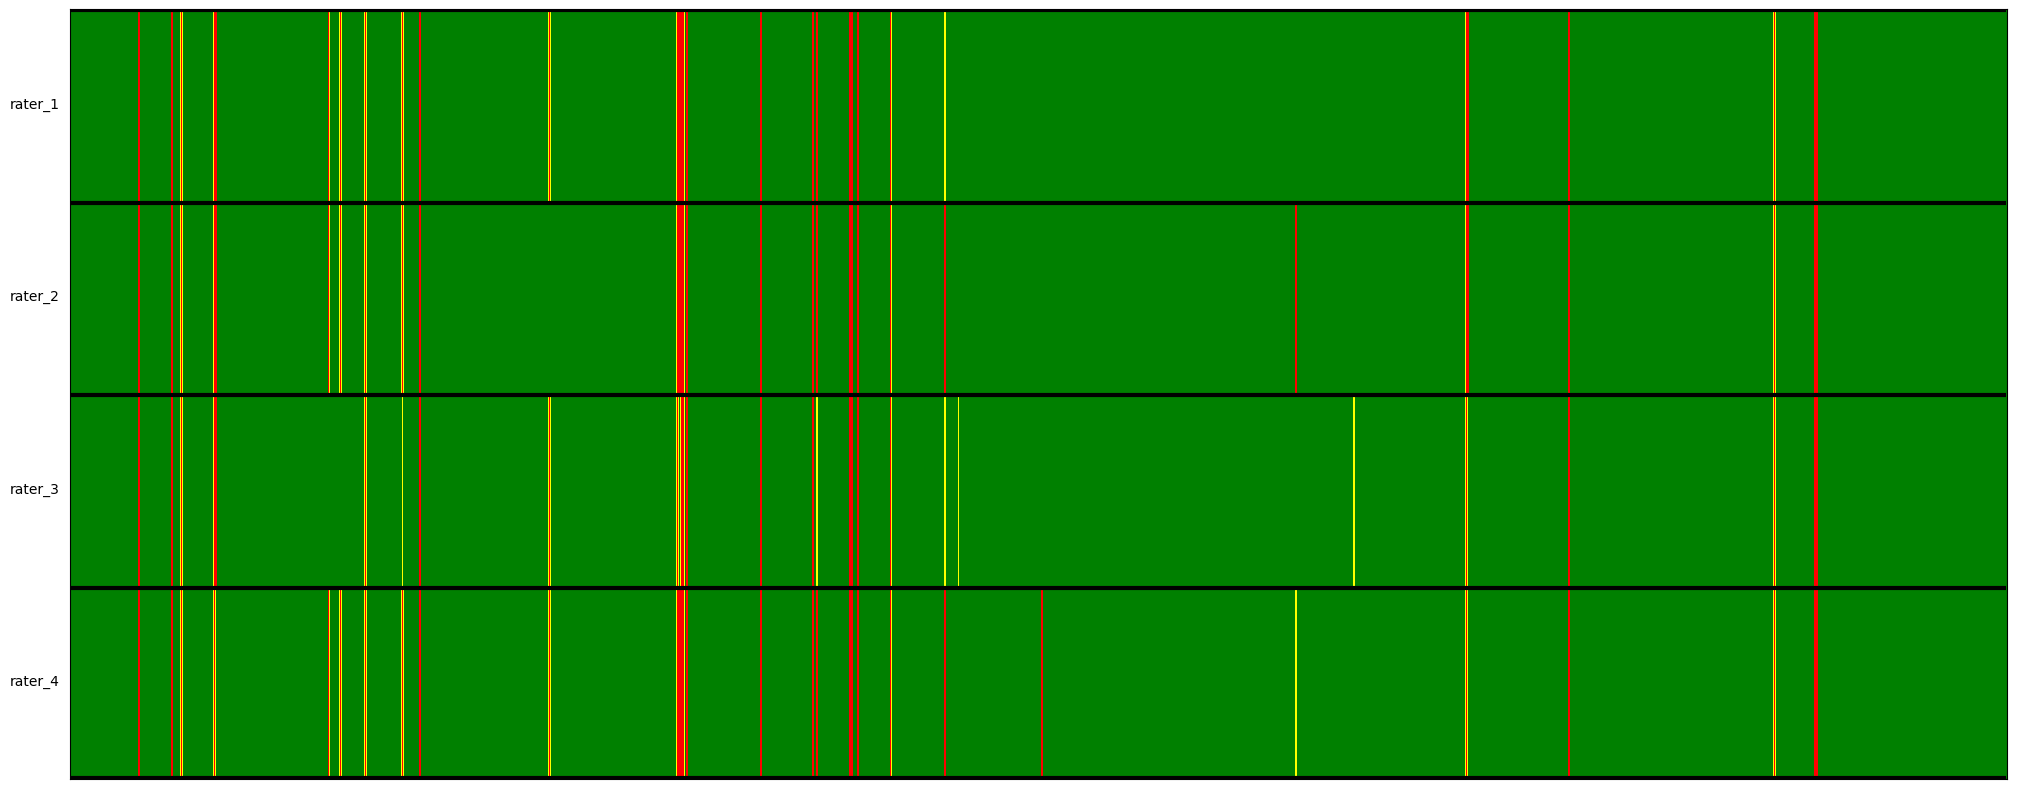

In [ ]:





print(df_mapped.head())
create_rating_plot(df_mapped)

##############3

def create_confusion_matrix_plot(cm, classes):
    f,ax = plt.subplots(1,1, figsize=(6,6))
    im = ax.imshow(cm, cmap='viridis', vmax=300)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(len(classes)):
        for j in range(len(classes)):
            #if cm[i,j] < .8:
            if cm[i,j] < 300:
                color = 'white'
            else:
                color = 'black'
            if cm[i,j] < 0:
                formatted_value = "{:.4f}".format(cm[i, j])
            else:
                formatted_value = int(cm[i, j])
            text = ax.text(j, i, formatted_value, ha="center", va="center", color=color, fontsize=20)
    ax.set_title("Confusion Matrix")
    accuarcy = np.trace(cm) / np.sum(cm)
    #ax.set_xlabel(f"Accuracy: {accuarcy}")
    print(f"Accuracy: {accuarcy}")
    f.tight_layout()
    plt.show()

#create_confusion_matrix_plot(total_cm, all_classes)